# Explore dataset distribution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

In [52]:
expansion = pd.read_csv("hf://datasets/openadmet/openadmet-expansionrx-challenge-train-data/expansion_data_train.csv") # use ML-ready dataset
polaris = pd.read_csv("/home/jeanshe/orcd/pool/OpenADMET/Data/polaris_data_converted.csv")
pharmabench = pd.read_csv("/home/jeanshe/orcd/pool/OpenADMET/Data/pharmabench_train_raw.csv")

In [53]:
expansion.head()

,Molecule Name,SMILES,LogD,KSOL,HLM CLint,MLM CLint,Caco-2 Permeability Papp A>B,Caco-2 Permeability Efflux,MPPB,MBPB,MGMB
0,E-0001321,CN1CCC[C@H]1COc1ccc(-c2nc3cc(-c4ccc5[nH]c(-c6c...,NaN,NaN,56.4,182.3,NaN,NaN,NaN,NaN,NaN
1,E-0001780,COc1ccc2c(c1)c1cc3cnccc3c(C)c1n2C,NaN,NaN,160.4,1351.1,NaN,NaN,NaN,NaN,NaN
2,E-0001827,Cc1c2ccncc2cc2c3cc(OCCCN4CCN(C)CC4)ccc3n(C)c12,NaN,NaN,NaN,193.5,NaN,NaN,NaN,NaN,NaN
3,E-0002019,CN(C)CCCOc1ccc(-c2nc3cc(NC(=O)c4ccc5[nH]c(-c6c...,NaN,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN
4,E-0002036,CN(C)CCCOc1ccc2nc(-c3ccc(-c4nc5ccc(OCCCN(C)C)c...,NaN,NaN,NaN,162.0,NaN,NaN,NaN,NaN,0.0122


In [54]:
endpoints = polaris.columns[2:11]
datasets = {
    "Expansion": expansion,
    "Polaris": polaris,
    "PharmaBench": pharmabench,
}

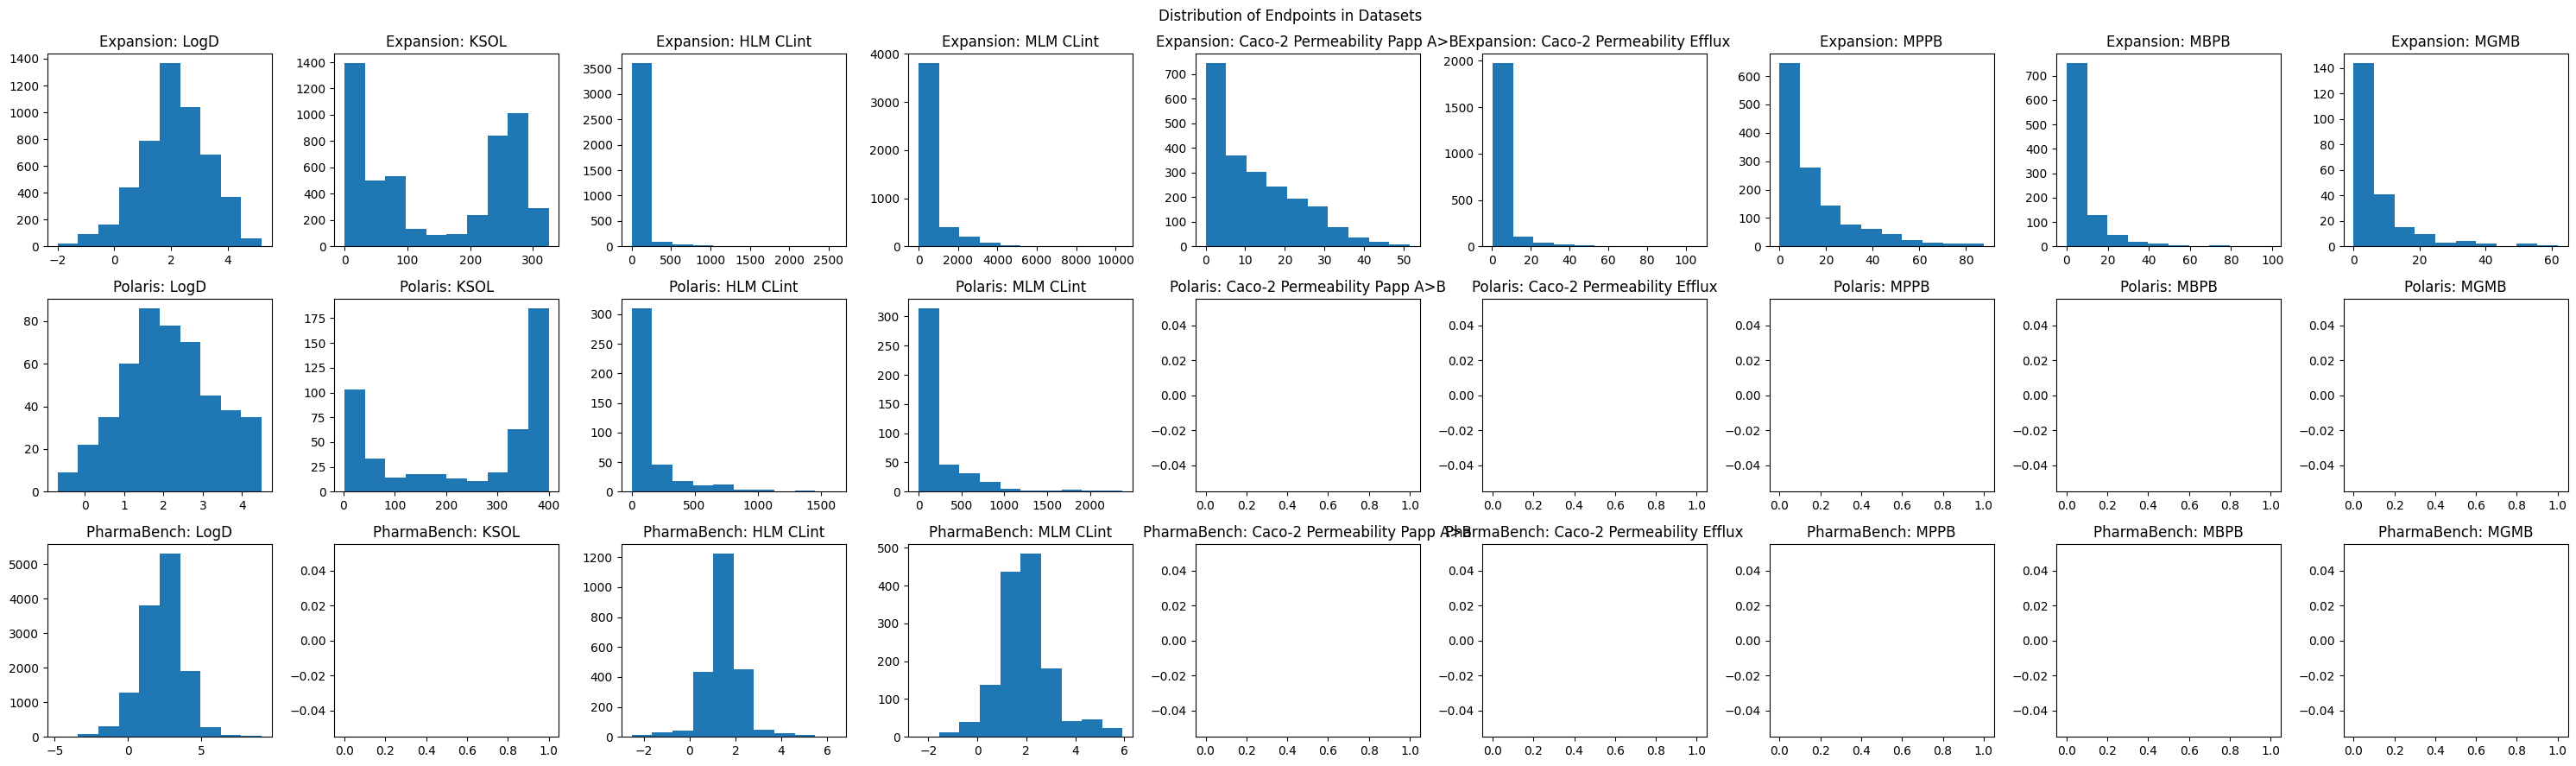

In [55]:
fig, axes = plt.subplots(len(datasets), len(endpoints), figsize=(30, 9))

for i, (name, dataset) in enumerate(datasets.items()):
    for j, endpoint in enumerate(endpoints):
        data = dataset[endpoint].dropna()
        axes[i, j].hist(data)
        axes[i, j].set_title(f'{name}: {endpoint}')

fig.suptitle("Distribution of Endpoints in Datasets")

plt.tight_layout()
plt.show()

The distributions show that ALL of the PharmaBench endpoints have already been log10'd, whereas only the LogD values for the Expansion and Polaris datasets have been log10'd. Let's generate a table similar to the Expansion tutorial that will allow us to effectively homogenize the scale of all of this data in order to combine it.

# Take log10 of all Expansion data endpoints

In [56]:
data = """Assay,Log_Scale,Multiplier,Log_name
LogD,False,1,LogD
KSOL,True,1e-6,LogS
HLM CLint,True,1,Log_HLM_CLint
MLM CLint,True,1,Log_MLM_CLint
Caco-2 Permeability Papp A>B,True,1e-6,Log_Caco_Papp_AB
Caco-2 Permeability Efflux,True,1,Log_Caco_ER
MPPB,True,1,Log_Mouse_PPB
MBPB,True,1,Log_Mouse_BPB
MGMB,True,1,Log_Mouse_MPB
"""
s = StringIO(data)
conversion_df = pd.read_csv(s)

# convert to a dictionary
conversion_dict = dict([(x[0], x[1:]) for x in conversion_df.values])
conversion_dict

{'LogD': array([False, 1.0, 'LogD'], dtype=object),
 'KSOL': array([True, 1e-06, 'LogS'], dtype=object),
 'HLM CLint': array([True, 1.0, 'Log_HLM_CLint'], dtype=object),
 'MLM CLint': array([True, 1.0, 'Log_MLM_CLint'], dtype=object),
 'Caco-2 Permeability Papp A>B': array([True, 1e-06, 'Log_Caco_Papp_AB'], dtype=object),
 'Caco-2 Permeability Efflux': array([True, 1.0, 'Log_Caco_ER'], dtype=object),
 'MPPB': array([True, 1.0, 'Log_Mouse_PPB'], dtype=object),
 'MBPB': array([True, 1.0, 'Log_Mouse_BPB'], dtype=object),
 'MGMB': array([True, 1.0, 'Log_Mouse_MPB'], dtype=object)}

In [57]:
log_expansion = expansion[["SMILES", "Molecule Name"]].copy()

In [58]:
expansion.columns

Index(['Molecule Name', 'SMILES', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint',
       'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB',
       'MBPB', 'MGMB'],
      dtype='object')

In [59]:
for col in expansion.columns[2:]:
    log_scale, multiplier, short_name = conversion_dict[col]
    log_expansion[short_name] = expansion[col].astype(float)
    if log_scale:
        log_expansion[short_name] += 1 # add 1 to avoid taking the log of 0
        log_expansion[short_name] = np.log10(log_expansion[short_name] * multiplier)

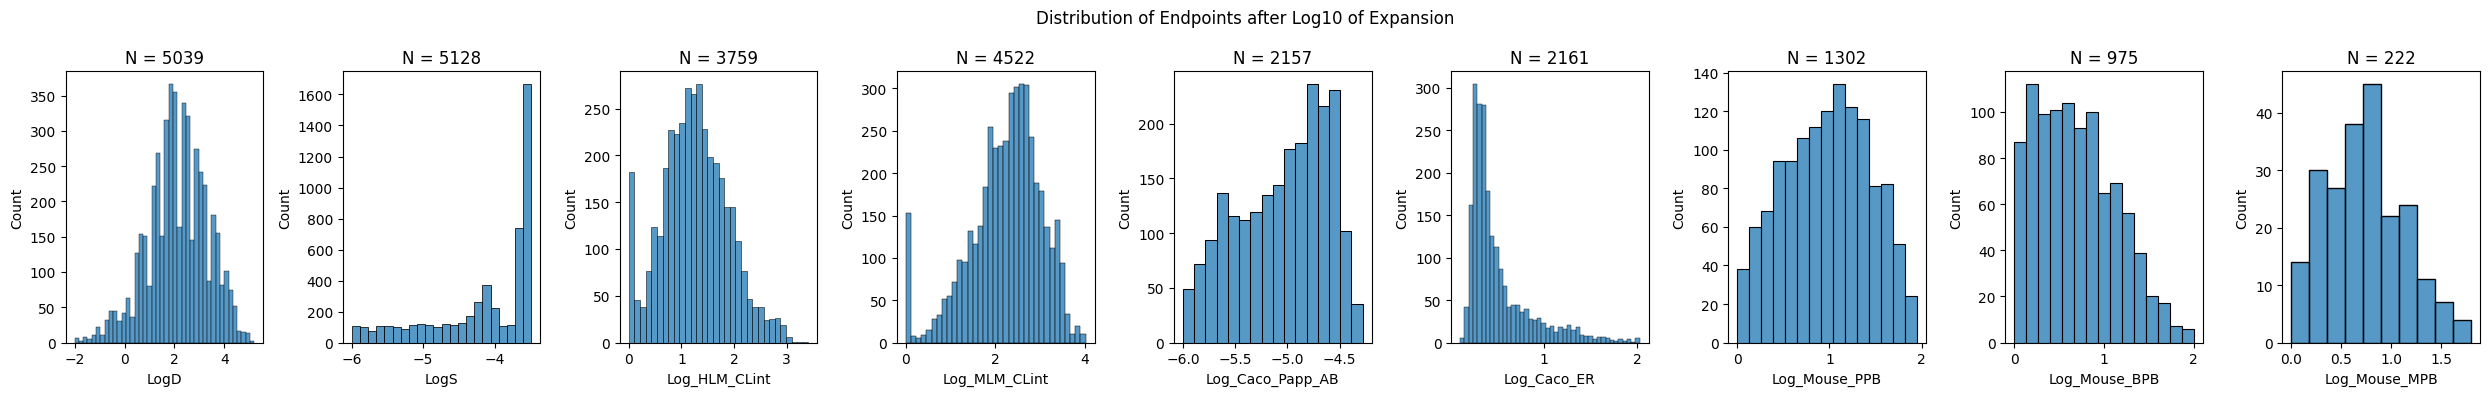

In [60]:
import seaborn as sns

dataset = log_expansion
fig, axes = plt.subplots(1, len(dataset.columns[2:]), figsize=(25, 4))

log_col_names = dataset.columns[2:]
for j, endpoint in enumerate(log_col_names):
    data = dataset[endpoint].dropna()
    ax = sns.histplot(dataset[endpoint], ax=axes[j])
    ax.set_title(f'N = {len(data)}')

fig.suptitle("Distribution of Endpoints after Log10 of Expansion")

plt.tight_layout()
plt.show()

# Take log10 of Polaris data

In [61]:
data = """Assay,Log_Scale,Multiplier,Log_name
LogD,False,1,LogD
KSOL,True,1e-6,LogS
HLM CLint,True,1,Log_HLM_CLint
MLM CLint,True,1,Log_MLM_CLint
"""
s = StringIO(data)
conversion_df = pd.read_csv(s)

# convert to a dictionary
conversion_dict = dict([(x[0], x[1:]) for x in conversion_df.values])
conversion_dict

{'LogD': array([False, 1.0, 'LogD'], dtype=object),
 'KSOL': array([True, 1e-06, 'LogS'], dtype=object),
 'HLM CLint': array([True, 1.0, 'Log_HLM_CLint'], dtype=object),
 'MLM CLint': array([True, 1.0, 'Log_MLM_CLint'], dtype=object)}

In [65]:
polaris = polaris.drop(['LogD modifier', 'KSOL modifier', 'HLM CLint modifier',
       'MLM CLint modifier', 'Caco-2 Permeability Papp A>B modifier',
       'Caco-2 Permeability Efflux modifier', 'MPPB modifier', 'MBPB modifier',
       'MGMB modifier', 'INCHIKEY'], axis=1)

In [66]:
log_polaris = polaris[["SMILES", "Molecule Name"]].copy()

In [69]:
polaris.columns

Index(['Molecule Name', 'SMILES', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint',
       'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB',
       'MBPB', 'MGMB'],
      dtype='object')

In [70]:
for col in polaris.columns[2:6]: # remaining columns have all NaNs
    log_scale, multiplier, short_name = conversion_dict[col]
    log_polaris[short_name] = polaris[col].astype(float)
    if log_scale:
        log_polaris[short_name] += 1 # add 1 to avoid taking the log of 0
        log_polaris[short_name] = np.log10(log_polaris[short_name] * multiplier)

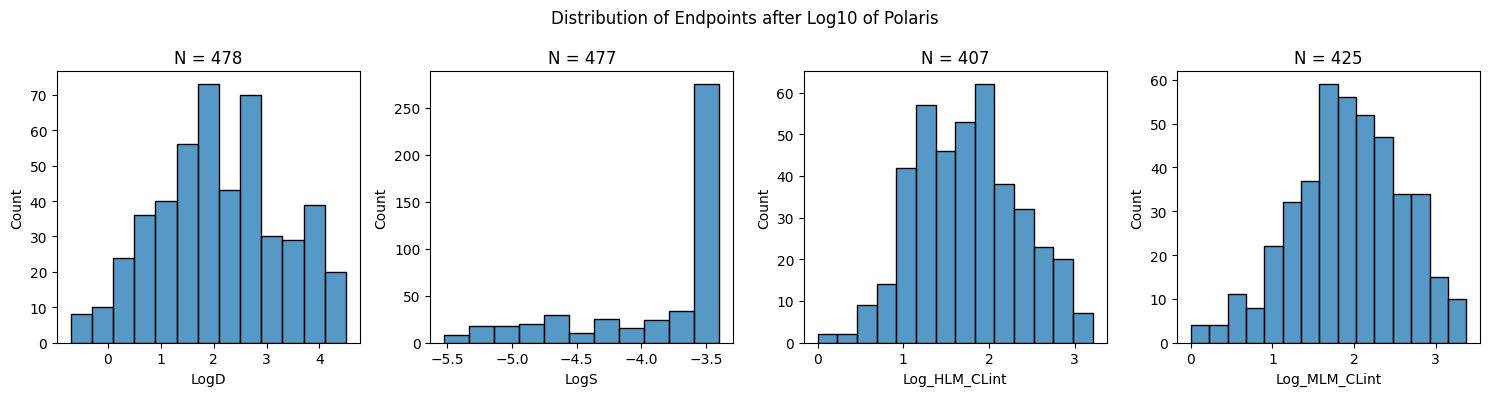

In [71]:
import seaborn as sns

dataset = log_polaris
fig, axes = plt.subplots(1, len(dataset.columns[2:]), figsize=(15, 4))

log_col_names = dataset.columns[2:]
for j, endpoint in enumerate(log_col_names):
    data = dataset[endpoint].dropna()
    ax = sns.histplot(dataset[endpoint], ax=axes[j])
    ax.set_title(f'N = {len(data)}')

fig.suptitle("Distribution of Endpoints after Log10 of Polaris")

plt.tight_layout()
plt.show()

# Combine all datasets into one csv

Standardize the SMILES such that all are canonical form.

In [73]:
from rdkit import Chem

def canonicalize_smile(smile):
    return Chem.CanonSmiles(smile)

log_expansion['SMILES'] = log_expansion['SMILES'].apply(canonicalize_smile)
log_polaris['SMILES'] = log_polaris['SMILES'].apply(canonicalize_smile)

In [74]:
pharmabench['SMILES'] = pharmabench['SMILES'].apply(canonicalize_smile)

# Merge converted_polaris, converted_expansion, and pharmabench altogther. Drop the duplicates with priority expansion > polaris > pharmabench

In [75]:
log_expansion.columns

Index(['SMILES', 'Molecule Name', 'LogD', 'LogS', 'Log_HLM_CLint',
       'Log_MLM_CLint', 'Log_Caco_Papp_AB', 'Log_Caco_ER', 'Log_Mouse_PPB',
       'Log_Mouse_BPB', 'Log_Mouse_MPB'],
      dtype='object')

In [76]:
log_polaris.columns

Index(['SMILES', 'Molecule Name', 'LogD', 'LogS', 'Log_HLM_CLint',
       'Log_MLM_CLint'],
      dtype='object')

In [78]:
pharmabench = pharmabench.drop(['Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB',
       'MBPB', 'MGMB', 'LogD modifier', 'KSOL modifier', 'HLM CLint modifier',
       'MLM CLint modifier', 'Caco-2 Permeability Papp A>B modifier',
       'Caco-2 Permeability Efflux modifier', 'MPPB modifier', 'MBPB modifier',
       'MGMB modifier', 'INCHIKEY'], axis=1)

In [79]:
pharmabench.columns

Index(['Molecule Name', 'SMILES', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint'], dtype='object')

In [80]:
pharmabench.columns = [
    'Molecule Name', 
    'SMILES', 
    'LogD', 
    'LogS', 
    'Log_HLM_CLint',
    'Log_MLM_CLint',
    ]

In [81]:
combined = pd.concat([log_expansion, log_polaris, pharmabench], axis=0)

In [82]:
combined.shape

(21771, 11)

In [84]:
combined.to_csv("Combined_Log10_Transformed_Canon_SMILES_ML_Ready.csv")